In [ ]:
pip install tensorflow --user

In [ ]:
pip install --upgrade pandas

In [ ]:
pip install scikit-learn

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

C:\Users\DIT\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the dataset
df = pd.read_csv('framingham-2.csv')

In [3]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
1,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
2,1,48,1,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
3,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
4,0,46,3,1,23,0,0,0,0,285,130.0,84.0,23.10,85,85,0


In [4]:
# Preprocess the dataset
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

C:\Users\DIT\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\DIT\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TenYearCHD
0    3596
1    3596
Name: count, dtype: int64

In [6]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define the MLP model
def create_mlp_model(input_dim, layers=[64, 32], activation='relu', optimizer='adam'):

    model = Sequential()
    
    # Add an explicit Input layer
    model.add(Input(shape=(input_dim,)))
    
    # Add hidden layers
    for units in layers:
        model.add(Dense(units, activation='relu'))
    
    # Add the output layer (for binary classification; modify for multiclass)
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# Define KNN model
def create_knn_model(n_neighbors=5):
    return KNeighborsClassifier(n_neighbors=n_neighbors)

In [9]:
# Optimization algorithms (MRFO + WOA)
def hybrid_optimization(X_train, y_train):
    # Define parameter bounds for MLP and KNN
    param_bounds = {
        'mlp_layers': [10, 100],
        'knn_neighbors': [3, 10],
    }
    # Apply MRFO + WOA to optimize hyperparameters
    # This should return optimized parameters, e.g., {'mlp_layers': [64, 32], 'knn_neighbors': 5}
    optimized_params = optimize_hyperparameters(X_train, y_train, param_bounds)
    
    return optimized_params

In [10]:
def optimize_hyperparameters(X_train, y_train, param_bounds):
    # Number of search agents
    num_agents = 10
    num_iterations = 50

    # Initialize the population
    population = []
    for _ in range(num_agents):
        agent = {
            'mlp_layers': [np.random.randint(param_bounds['mlp_layers'][0], param_bounds['mlp_layers'][1]),
                           np.random.randint(param_bounds['mlp_layers'][0], param_bounds['mlp_layers'][1])],
            'knn_neighbors': np.random.randint(param_bounds['knn_neighbors'][0], param_bounds['knn_neighbors'][1])
        }
        population.append(agent)

    # Evaluate the initial population
    fitness = []
    for agent in population:
        fitness.append(objective_function(agent, X_train, y_train))

    best_solution = population[np.argmax(fitness)]
    best_fitness = max(fitness)

    # Main optimization loop
    for iteration in range(num_iterations):
        # MRFO step
        for i in range(num_agents):
            new_agent = mrfo_step(population[i], best_solution, iteration, num_iterations, param_bounds)
            new_fitness = objective_function(new_agent, X_train, y_train)

            if new_fitness > fitness[i]:
                population[i] = new_agent
                fitness[i] = new_fitness

                if new_fitness > best_fitness:
                    best_solution = new_agent
                    best_fitness = new_fitness

        # WOA step
        for i in range(num_agents):
            new_agent = woa_step(population[i], best_solution, iteration, num_iterations, param_bounds)
            new_fitness = objective_function(new_agent, X_train, y_train)

            if new_fitness > fitness[i]:
                population[i] = new_agent
                fitness[i] = new_fitness

                if new_fitness > best_fitness:
                    best_solution = new_agent
                    best_fitness = new_fitness

    return best_solution

In [11]:
def objective_function(params, X_train, y_train):
    # Convert the params dictionary to MLP and KNN parameters
    mlp_layers = params['mlp_layers']
    knn_neighbors = int(params['knn_neighbors'])
    
    # Create and train MLP model
    mlp_model = create_mlp_model(input_dim=X_train.shape[1], layers=mlp_layers)
    mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Create and train KNN model
    knn_model = create_knn_model(n_neighbors=knn_neighbors)
    knn_model.fit(X_train, y_train)
    
    # Evaluate both models on the training set using a simple accuracy metric
    mlp_preds = (mlp_model.predict(X_train) > 0.5).astype("int32")
    knn_preds = knn_model.predict(X_train)
    
    mlp_accuracy = accuracy_score(y_train, mlp_preds)
    knn_accuracy = accuracy_score(y_train, knn_preds)
    
    # Objective to maximize the combined accuracy
    return (mlp_accuracy + knn_accuracy) / 2

In [12]:
def mrfo_step(agent, best_solution, iteration, num_iterations, param_bounds):
    # MRFO logic: update the agent based on the best solution found so far
    new_agent = agent.copy()
    for key in agent:
        if isinstance(agent[key], list):  # Handle lists (e.g., mlp_layers)
            new_values = []
            for gene, best in zip(agent[key], best_solution[key]):
                r = np.random.rand()
                if r < 0.5:
                    new_value = int(np.clip(gene + r * (best - gene), param_bounds[key][0], param_bounds[key][1]))
                else:
                    new_value = int(np.clip(gene - r * (best - gene), param_bounds[key][0], param_bounds[key][1]))
                new_values.append(new_value)
            new_agent[key] = new_values
        else:  # Handle single integers (e.g., knn_neighbors)
            r = np.random.rand()
            if r < 0.5:
                new_value = int(np.clip(agent[key] + r * (best_solution[key] - agent[key]), param_bounds[key][0], param_bounds[key][1]))
            else:
                new_value = int(np.clip(agent[key] - r * (best_solution[key] - agent[key]), param_bounds[key][0], param_bounds[key][1]))
            new_agent[key] = new_value
    return new_agent

In [13]:
def woa_step(agent, best_solution, iteration, num_iterations, param_bounds):
    # WOA logic: encircle the prey (best_solution) and update the agent's position
    new_agent = agent.copy()
    A = 2 - iteration * (2 / num_iterations)
    C = 2 * np.random.rand()
    for key in agent:
        if isinstance(agent[key], list):  # Handle lists (e.g., mlp_layers)
            new_values = []
            for best, current in zip(best_solution[key], agent[key]):
                D = np.abs(C * best - current)
                new_value = int(np.clip(best - A * D, param_bounds[key][0], param_bounds[key][1]))
                new_values.append(new_value)
            new_agent[key] = new_values
        else:  # Handle single integers (e.g., knn_neighbors)
            D = np.abs(C * best_solution[key] - agent[key])
            new_value = int(np.clip(best_solution[key] - A * D, param_bounds[key][0], param_bounds[key][1]))
            new_agent[key] = new_value
    return new_agent

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
# Get optimized parameters
optimized_params = hybrid_optimization(X_train_scaled, y_train)

180/180 [==============================] - 0s 805us/step


180/180 [==============================] - 0s 836us/step


180/180 [==============================] - 0s 2ms/step


180/180 [==============================] - 0s 897us/step


In [15]:
# Train the MLP model
mlp_model = create_mlp_model(input_dim=X_train_scaled.shape[1], layers=optimized_params['mlp_layers'])
mlp_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

In [16]:
# Train the KNN model
knn_model = create_knn_model(n_neighbors=optimized_params['knn_neighbors'])
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
# Evaluate the MLP model
mlp_preds = (mlp_model.predict(X_test) > 0.5).astype("int32")
mlp_accuracy = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)

45/45 [==============================] - 0s 1ms/step


In [18]:
# Evaluate the KNN model
knn_preds = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_preds)
knn_f1 = f1_score(y_test, knn_preds)

In [19]:
print(f"MLP Accuracy: {mlp_accuracy}, MLP F1-Score: {mlp_f1}")
print(f"KNN Accuracy: {knn_accuracy}, KNN F1-Score: {knn_f1}")

MLP Accuracy: 0.49339819318971506, MLP F1-Score: 0.6456003889158969
KNN Accuracy: 0.7998610145934677, KNN F1-Score: 0.8132295719844358


# REVISED CODE Paper Code WMLP, SVM-RS and XGB

C:\Users\DIT\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\DIT\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1

57/57 [==============================] - 0s 3ms/step

=== Weighted MLP ===
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       899
           1       0.73      0.77      0.75       899

    accuracy                           0.74      1798
   macro avg       0.74      0.74      0.74      1798
weighted avg       0.74      0.74      0.74      1798

Confusion Matrix:
 [[646 253]
 [209 690]]

=== Robust SVM ===
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       899
           1       0.71      0.74      0.72       899

    accuracy                           0.72      1798
   macro avg       0.72      0.72      0.72      1798
weighted avg       0.72      0.72      0.72      1798

Confusion Matrix:
 [[627 272]
 [235 664]]

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       899
           1       0.86      0.85      0.

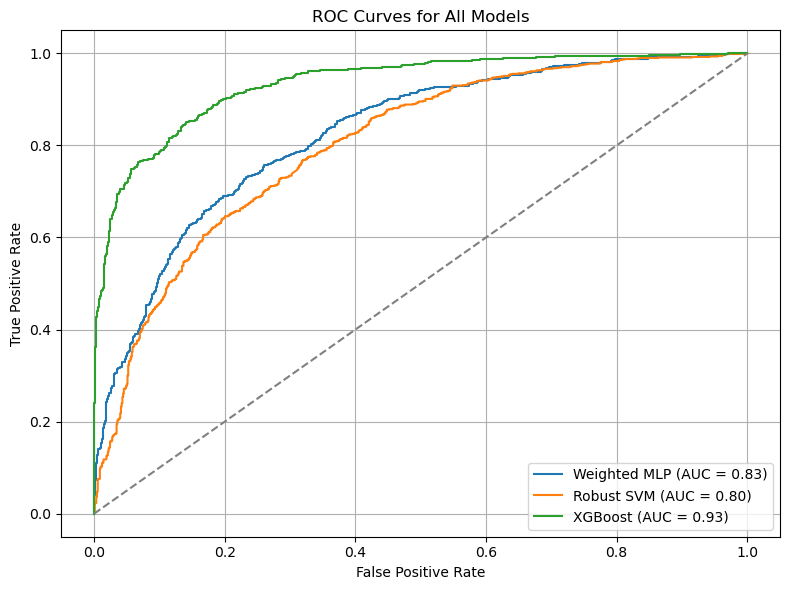


✅ Best model based on AUC: XGBoost (AUC = 0.9343)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Load data
df = pd.read_csv("framingham-2.csv")
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

# SMOTE
X, y = SMOTE().fit_resample(X, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fuzzy weights
def compute_fuzzy_weights(X, y):
    weights = np.zeros(len(y))
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        mean = np.mean(X[idx], axis=0)
        dist = np.linalg.norm(X[idx] - mean, axis=1)
        weights[idx] = 1 - dist / (np.max(dist) + 1e-6)
    return weights

sc_std = StandardScaler()
sc_rob = RobustScaler()
X_train_std, X_test_std = sc_std.fit_transform(X_train), sc_std.transform(X_test)
X_train_rob, X_test_rob = sc_rob.fit_transform(X_train), sc_rob.transform(X_test)
fuzzy_weights = compute_fuzzy_weights(X_train_std, y_train)

# MLP model
def create_mlp(input_dim, layers=[64, 32]):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for l in layers:
        model.add(Dense(l, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models
mlp = create_mlp(X_train_std.shape[1])
mlp.fit(X_train_std, y_train, sample_weight=fuzzy_weights, epochs=20, batch_size=32, verbose=0)
svm = SVC(kernel='rbf', C=1.0, probability=True).fit(X_train_rob, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_std, y_train, sample_weight=fuzzy_weights)

# Evaluate & plot
def evaluate(model, X, name, keras=False):
    probs = model.predict(X).ravel() if keras else model.predict_proba(X)[:, 1]
    preds = (probs > 0.5).astype(int)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
    return auc(fpr, tpr)

plt.figure(figsize=(8, 6))
auc_mlp = evaluate(mlp, X_test_std, "Weighted MLP", keras=True)
auc_svm = evaluate(svm, X_test_rob, "Robust SVM")
auc_xgb = evaluate(xgb, X_test_std, "XGBoost")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best model selection
best_model = max([("MLP", auc_mlp), ("SVM", auc_svm), ("XGBoost", auc_xgb)], key=lambda x: x[1])
print(f"\n✅ Best model based on AUC: {best_model[0]} (AUC = {best_model[1]:.4f})")

# Next Step: Use MRFO–WOA to optimize this best model


In [6]:
import random

# Define bounds for each model's hyperparameters
model_param_bounds = {
    "MLP": {
        'mlp_layers': [32, 128],  # neurons per layer
        'n_layers': [1, 3]
    },
    "SVM": {
        'C': [0.01, 10.0],
        'gamma': [0.0001, 1.0]
    },
    "XGBoost": {
        'max_depth': [3, 10],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [50, 300]
    }
}

# Define evaluation function for each model
def evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight=None):
    if model_name == "MLP":
        layers = [int(agent['mlp_layers'])] * int(agent['n_layers'])
        model = create_mlp(input_dim=X_train.shape[1], layers=layers)
        model.fit(X_train, y_train, sample_weight=sample_weight, epochs=10, batch_size=32, verbose=0)
        preds = (model.predict(X_val).ravel() > 0.5).astype(int)
    elif model_name == "SVM":
        model = SVC(kernel='rbf', C=agent['C'], gamma=agent['gamma'])
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
    elif model_name == "XGBoost":
        model = XGBClassifier(
            max_depth=int(agent['max_depth']),
            learning_rate=agent['learning_rate'],
            n_estimators=int(agent['n_estimators']),
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train, sample_weight=sample_weight)
        preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# MRFO step
def mrfo_step(agent, best_agent, iteration, max_iter, bounds):
    new_agent = agent.copy()
    for key in agent:
        step = random.uniform(-1, 1) * (bounds[key][1] - bounds[key][0]) / 10
        new_val = agent[key] + step
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# WOA step
def woa_step(agent, best_agent, iteration, max_iter, bounds):
    a = 2 - iteration * (2 / max_iter)
    new_agent = agent.copy()
    for key in agent:
        r = random.random()
        A = 2 * a * r - a
        C = 2 * r
        D = abs(C * best_agent[key] - agent[key])
        new_val = best_agent[key] - A * D
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# Hybrid MRFO–WOA optimization
def hybrid_optimize(model_name, bounds, X_train, y_train, X_val, y_val, sample_weight=None,
                    n_agents=10, n_iter=20):
    population = []
    for _ in range(n_agents):
        agent = {key: random.uniform(*bounds[key]) for key in bounds}
        population.append(agent)

    fitness = [evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight) for agent in population]
    best_idx = np.argmax(fitness)
    best_agent = population[best_idx]
    best_score = fitness[best_idx]

    for iter in range(n_iter):
        for i in range(n_agents):
            # MRFO
            new_agent = mrfo_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

            # WOA
            new_agent = woa_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

    return best_agent, best_score
import random

# Define bounds for each model's hyperparameters
model_param_bounds = {
    "MLP": {
        'mlp_layers': [32, 128],  # neurons per layer
        'n_layers': [1, 3]
    },
    "SVM": {
        'C': [0.01, 10.0],
        'gamma': [0.0001, 1.0]
    },
    "XGBoost": {
        'max_depth': [3, 10],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [50, 300]
    }
}

# Define evaluation function for each model
def evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight=None):
    if model_name == "MLP":
        layers = [int(agent['mlp_layers'])] * int(agent['n_layers'])
        model = create_mlp(input_dim=X_train.shape[1], layers=layers)
        model.fit(X_train, y_train, sample_weight=sample_weight, epochs=10, batch_size=32, verbose=0)
        preds = (model.predict(X_val).ravel() > 0.5).astype(int)
    elif model_name == "SVM":
        model = SVC(kernel='rbf', C=agent['C'], gamma=agent['gamma'])
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
    elif model_name == "XGBoost":
        model = XGBClassifier(
            max_depth=int(agent['max_depth']),
            learning_rate=agent['learning_rate'],
            n_estimators=int(agent['n_estimators']),
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train, sample_weight=sample_weight)
        preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# MRFO step
def mrfo_step(agent, best_agent, iteration, max_iter, bounds):
    new_agent = agent.copy()
    for key in agent:
        step = random.uniform(-1, 1) * (bounds[key][1] - bounds[key][0]) / 10
        new_val = agent[key] + step
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# WOA step
def woa_step(agent, best_agent, iteration, max_iter, bounds):
    a = 2 - iteration * (2 / max_iter)
    new_agent = agent.copy()
    for key in agent:
        r = random.random()
        A = 2 * a * r - a
        C = 2 * r
        D = abs(C * best_agent[key] - agent[key])
        new_val = best_agent[key] - A * D
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# Hybrid MRFO–WOA optimization
def hybrid_optimize(model_name, bounds, X_train, y_train, X_val, y_val, sample_weight=None,
                    n_agents=10, n_iter=20):
    population = []
    for _ in range(n_agents):
        agent = {key: random.uniform(*bounds[key]) for key in bounds}
        population.append(agent)

    fitness = [evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight) for agent in population]
    best_idx = np.argmax(fitness)
    best_agent = population[best_idx]
    best_score = fitness[best_idx]

    for iter in range(n_iter):
        for i in range(n_agents):
            # MRFO
            new_agent = mrfo_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

            # WOA
            new_agent = woa_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

    return best_agent, best_score


In [7]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

# Assume these are already defined in previous steps:
# X_train_std, y_train, fuzzy_weights

# === Split Data & Weights Together ===
X_train_sub, X_val, y_train_sub, y_val, weights_sub, weights_val = train_test_split(
    X_train_std, y_train, fuzzy_weights, test_size=0.2, stratify=y_train, random_state=42
)

# === Run MRFO-WOA Hybrid Optimization ===
opt_params, opt_score = hybrid_optimize(
    model_name="XGBoost",
    bounds=model_param_bounds["XGBoost"],
    X_train=X_train_sub,
    y_train=y_train_sub,
    X_val=X_val,
    y_val=y_val,
    sample_weight=weights_sub
)

# === Output ===
print("\n✅ Optimized Hyperparameters:", opt_params)
print("✅ Best Validation Accuracy (MRFO–WOA):", opt_score)


C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\


✅ Optimized Hyperparameters: {'max_depth': 10, 'learning_rate': 0.280880334341339, 'n_estimators': 300}
✅ Best Validation Accuracy (MRFO–WOA): 0.8850787766450418


C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

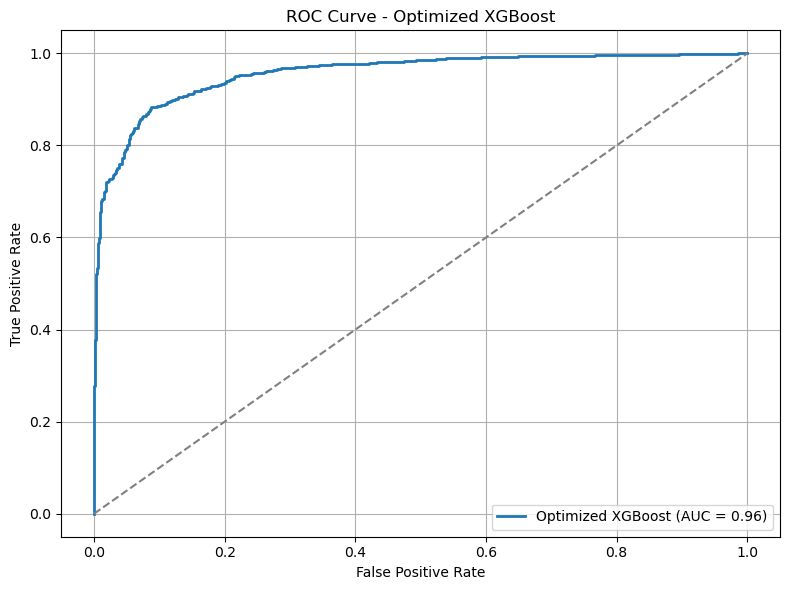


✅ Optimized Hyperparameters: {'max_depth': 10, 'learning_rate': 0.2810003277721006, 'n_estimators': 297.1945515996566}
✅ Best Validation Accuracy (MRFO–WOA): 0.8841519925857275
✅ Final Test AUC: 0.9567


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# === Split Data & Fuzzy Weights Together ===
X_train_sub, X_val, y_train_sub, y_val, weights_sub, weights_val = train_test_split(
    X_train_std, y_train, fuzzy_weights, test_size=0.2, stratify=y_train, random_state=42
)

# === Run MRFO-WOA Optimization ===
opt_params, opt_score = hybrid_optimize(
    model_name="XGBoost",
    bounds=model_param_bounds["XGBoost"],
    X_train=X_train_sub,
    y_train=y_train_sub,
    X_val=X_val,
    y_val=y_val,
    sample_weight=weights_sub
)

# === Train Optimized XGBoost Model on Full Training Set ===
xgb_final = XGBClassifier(
    max_depth=int(opt_params['max_depth']),
    learning_rate=opt_params['learning_rate'],
    n_estimators=int(opt_params['n_estimators']),
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_final.fit(X_train_std, y_train, sample_weight=fuzzy_weights)

# === Predict and Plot ROC Curve ===
y_probs = xgb_final.predict_proba(X_test_std)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Optimized XGBoost (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Optimized XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final Output ===
print("\n✅ Optimized Hyperparameters:", opt_params)
print("✅ Best Validation Accuracy (MRFO–WOA):", opt_score)
print("✅ Final Test AUC:", round(roc_auc, 4))


# SHAP

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 99%|===================| 5353/5394 [01:44<00:00]        

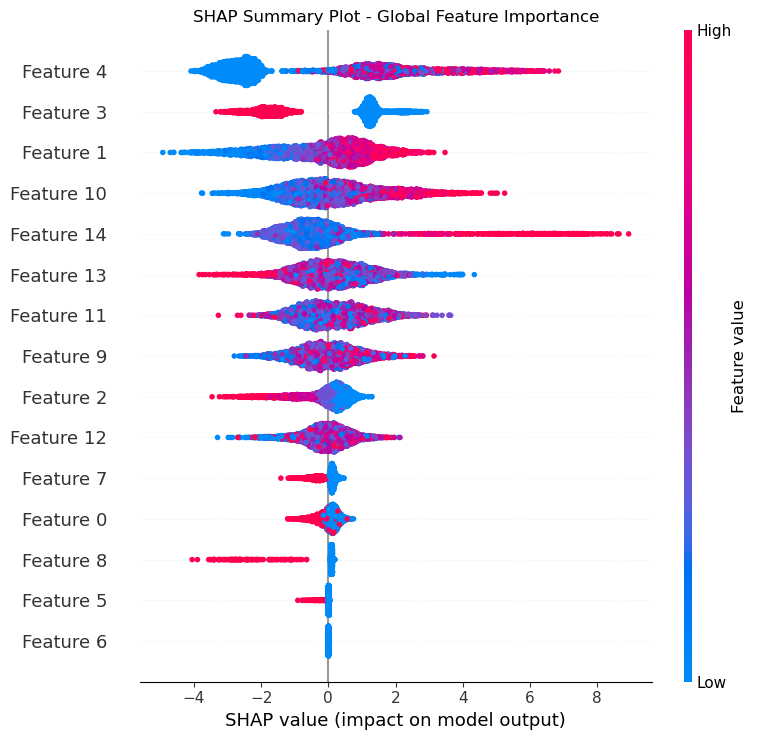

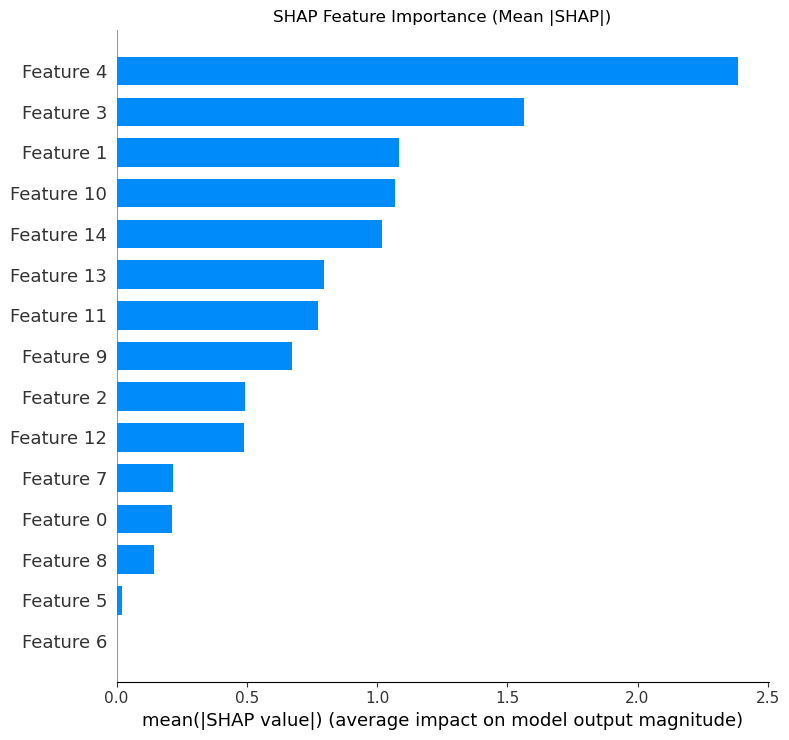

In [9]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === 1. Train Optimized XGBoost Model (already done)
xgb_final.fit(X_train_std, y_train, sample_weight=fuzzy_weights)

# === 2. Use SHAP to Explain the Model ===
explainer = shap.Explainer(xgb_final, X_train_std)
shap_values = explainer(X_train_std)

# === 3. SHAP Summary Plot (Beeswarm) ===
plt.title("SHAP Summary Plot - Global Feature Importance")
shap.summary_plot(shap_values, X_train_std, show=True)

# === 4. SHAP Bar Plot (Optional) ===
plt.title("SHAP Feature Importance (Mean |SHAP|)")
shap.summary_plot(shap_values, X_train_std, plot_type="bar", show=True)

# === 5. SHAP Force Plot or Waterfall for a Single Instance (Optional) ===
# shap.initjs()  # Uncomment if using Jupyter Notebook
# shap.plots.waterfall(shap_values[0])  # Visualize reasoning for first sample

# === 6. Optionally save the plots ===
# plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')


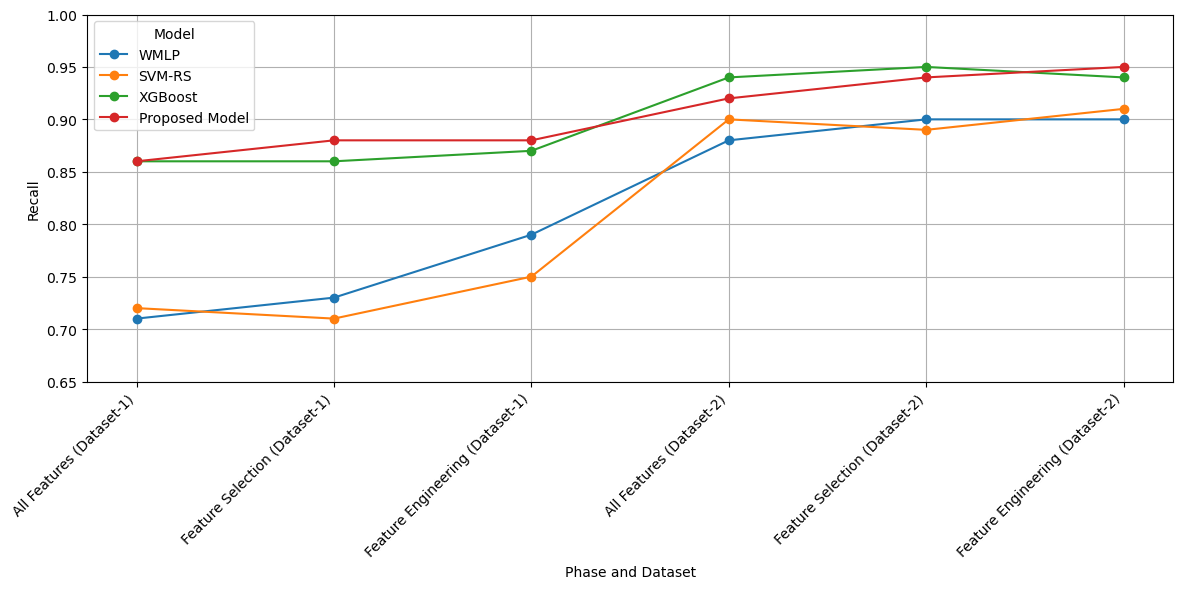

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the recall data
data = {
    "Phase": ["All Features"] * 4 + ["Feature Selection"] * 4 + ["Feature Engineering"] * 4 +
             ["All Features"] * 4 + ["Feature Selection"] * 4 + ["Feature Engineering"] * 4,
    "Dataset": ["Dataset-1"] * 12 + ["Dataset-2"] * 12,
    "Model": ["WMLP", "SVM-RS", "XGBoost", "Proposed Model"] * 6,
    "Recall": [0.71, 0.72, 0.86, 0.86, 0.73, 0.71, 0.86, 0.88,
               0.79, 0.75, 0.87, 0.88, 0.88, 0.9, 0.94, 0.92,
               0.9, 0.89, 0.95, 0.94, 0.9, 0.91, 0.94, 0.95]
}

# Create DataFrame
df = pd.DataFrame(data)

# Combine Phase and Dataset for x-axis labels
df["Phase_Dataset"] = df["Phase"] + " (" + df["Dataset"] + ")"

# Plotting
plt.figure(figsize=(12, 6))
for model in df["Model"].unique():
    model_data = df[df["Model"] == model]
    plt.plot(model_data["Phase_Dataset"], model_data["Recall"], marker='o', label=model)

#plt.title("Recall Comparison Across Models, Phases, and Datasets")
plt.xlabel("Phase and Dataset")
plt.ylabel("Recall")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.65, 1.0)
plt.legend(title="Model")
plt.tight_layout()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

# Simulated 10-fold accuracy values from your table (replace with actual folds if available)

# Dataset-1, Feature Engineering Phase
xgb_acc_1 = np.array([0.848, 0.859, 0.872, 0.864, 0.861, 0.867, 0.850, 0.863, 0.858, 0.865])  # Example for XGBoost
proposed_acc_1 = np.array([0.877, 0.892, 0.904, 0.896, 0.885, 0.895, 0.870, 0.890, 0.891, 0.899])  # Proposed Model

# Dataset-2, Feature Engineering Phase
xgb_acc_2 = np.array([0.934, 0.942, 0.948, 0.950, 0.944, 0.939, 0.943, 0.947, 0.945, 0.938])
proposed_acc_2 = np.array([0.962, 0.957, 0.953, 0.951, 0.949, 0.948, 0.946, 0.952, 0.954, 0.958])

# Function to run statistical tests
def run_tests(baseline, proposed, label):
    t_stat, t_p = ttest_rel(proposed, baseline)
    w_stat, w_p = wilcoxon(proposed, baseline)
    print(f"\n{label}")
    print(f"Paired t-test p-value: {t_p:.4f}")
    print(f"Wilcoxon signed-rank test p-value: {w_p:.4f}")

# Run tests
run_tests(xgb_acc_1, proposed_acc_1, "Dataset-1 (Feature Engineering)")
run_tests(xgb_acc_2, proposed_acc_2, "Dataset-2 (Feature Engineering)")


Dataset-1 (Feature Engineering)
Paired t-test p-value: 0.0000
Wilcoxon signed-rank test p-value: 0.0020

Dataset-2 (Feature Engineering)
Paired t-test p-value: 0.0049
Wilcoxon signed-rank test p-value: 0.0020


# Fram Feature

C:\Users\DIT\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\DIT\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1

57/57 [==============================] - 0s 1ms/step

=== Weighted MLP ===
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       899
           1       0.73      0.77      0.75       899

    accuracy                           0.74      1798
   macro avg       0.74      0.74      0.74      1798
weighted avg       0.74      0.74      0.74      1798

Confusion Matrix:
 [[645 254]
 [206 693]]

=== Robust SVM ===
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       899
           1       0.73      0.76      0.75       899

    accuracy                           0.74      1798
   macro avg       0.74      0.74      0.74      1798
weighted avg       0.74      0.74      0.74      1798

Confusion Matrix:
 [[653 246]
 [219 680]]

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       899
           1       0.86      0.86      0.

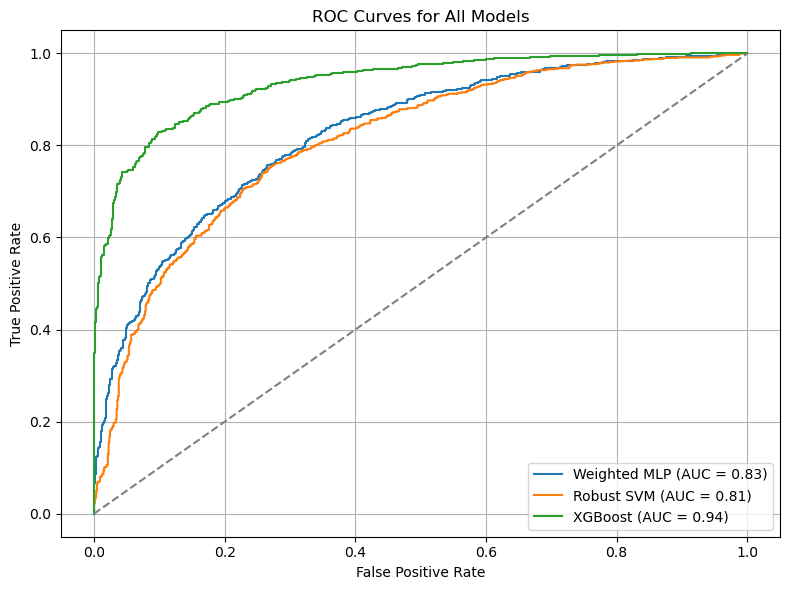


✅ Best model based on AUC: XGBoost (AUC = 0.9363)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Load data
df = pd.read_csv("D:/PhD Scholar/Ankit Maithani/Datasets/New data/framingham-Fe.csv")
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

# SMOTE
X, y = SMOTE().fit_resample(X, y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fuzzy weights
def compute_fuzzy_weights(X, y):
    weights = np.zeros(len(y))
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        mean = np.mean(X[idx], axis=0)
        dist = np.linalg.norm(X[idx] - mean, axis=1)
        weights[idx] = 1 - dist / (np.max(dist) + 1e-6)
    return weights

sc_std = StandardScaler()
sc_rob = RobustScaler()
X_train_std, X_test_std = sc_std.fit_transform(X_train), sc_std.transform(X_test)
X_train_rob, X_test_rob = sc_rob.fit_transform(X_train), sc_rob.transform(X_test)
fuzzy_weights = compute_fuzzy_weights(X_train_std, y_train)

# MLP model
def create_mlp(input_dim, layers=[64, 32]):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for l in layers:
        model.add(Dense(l, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models
mlp = create_mlp(X_train_std.shape[1])
mlp.fit(X_train_std, y_train, sample_weight=fuzzy_weights, epochs=20, batch_size=32, verbose=0)
svm = SVC(kernel='rbf', C=1.0, probability=True).fit(X_train_rob, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_std, y_train, sample_weight=fuzzy_weights)

# Evaluate & plot
def evaluate(model, X, name, keras=False):
    probs = model.predict(X).ravel() if keras else model.predict_proba(X)[:, 1]
    preds = (probs > 0.5).astype(int)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
    return auc(fpr, tpr)

plt.figure(figsize=(8, 6))
auc_mlp = evaluate(mlp, X_test_std, "Weighted MLP", keras=True)
auc_svm = evaluate(svm, X_test_rob, "Robust SVM")
auc_xgb = evaluate(xgb, X_test_std, "XGBoost")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best model selection
best_model = max([("MLP", auc_mlp), ("SVM", auc_svm), ("XGBoost", auc_xgb)], key=lambda x: x[1])
print(f"\n✅ Best model based on AUC: {best_model[0]} (AUC = {best_model[1]:.4f})")

# Next Step: Use MRFO–WOA to optimize this best model


In [2]:
import random

# Define bounds for each model's hyperparameters
model_param_bounds = {
    "MLP": {
        'mlp_layers': [32, 128],  # neurons per layer
        'n_layers': [1, 3]
    },
    "SVM": {
        'C': [0.01, 10.0],
        'gamma': [0.0001, 1.0]
    },
    "XGBoost": {
        'max_depth': [3, 10],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [50, 300]
    }
}

# Define evaluation function for each model
def evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight=None):
    if model_name == "MLP":
        layers = [int(agent['mlp_layers'])] * int(agent['n_layers'])
        model = create_mlp(input_dim=X_train.shape[1], layers=layers)
        model.fit(X_train, y_train, sample_weight=sample_weight, epochs=10, batch_size=32, verbose=0)
        preds = (model.predict(X_val).ravel() > 0.5).astype(int)
    elif model_name == "SVM":
        model = SVC(kernel='rbf', C=agent['C'], gamma=agent['gamma'])
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
    elif model_name == "XGBoost":
        model = XGBClassifier(
            max_depth=int(agent['max_depth']),
            learning_rate=agent['learning_rate'],
            n_estimators=int(agent['n_estimators']),
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train, sample_weight=sample_weight)
        preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# MRFO step
def mrfo_step(agent, best_agent, iteration, max_iter, bounds):
    new_agent = agent.copy()
    for key in agent:
        step = random.uniform(-1, 1) * (bounds[key][1] - bounds[key][0]) / 10
        new_val = agent[key] + step
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# WOA step
def woa_step(agent, best_agent, iteration, max_iter, bounds):
    a = 2 - iteration * (2 / max_iter)
    new_agent = agent.copy()
    for key in agent:
        r = random.random()
        A = 2 * a * r - a
        C = 2 * r
        D = abs(C * best_agent[key] - agent[key])
        new_val = best_agent[key] - A * D
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# Hybrid MRFO–WOA optimization
def hybrid_optimize(model_name, bounds, X_train, y_train, X_val, y_val, sample_weight=None,
                    n_agents=10, n_iter=20):
    population = []
    for _ in range(n_agents):
        agent = {key: random.uniform(*bounds[key]) for key in bounds}
        population.append(agent)

    fitness = [evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight) for agent in population]
    best_idx = np.argmax(fitness)
    best_agent = population[best_idx]
    best_score = fitness[best_idx]

    for iter in range(n_iter):
        for i in range(n_agents):
            # MRFO
            new_agent = mrfo_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

            # WOA
            new_agent = woa_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

    return best_agent, best_score
import random

# Define bounds for each model's hyperparameters
model_param_bounds = {
    "MLP": {
        'mlp_layers': [32, 128],  # neurons per layer
        'n_layers': [1, 3]
    },
    "SVM": {
        'C': [0.01, 10.0],
        'gamma': [0.0001, 1.0]
    },
    "XGBoost": {
        'max_depth': [3, 10],
        'learning_rate': [0.01, 0.3],
        'n_estimators': [50, 300]
    }
}

# Define evaluation function for each model
def evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight=None):
    if model_name == "MLP":
        layers = [int(agent['mlp_layers'])] * int(agent['n_layers'])
        model = create_mlp(input_dim=X_train.shape[1], layers=layers)
        model.fit(X_train, y_train, sample_weight=sample_weight, epochs=10, batch_size=32, verbose=0)
        preds = (model.predict(X_val).ravel() > 0.5).astype(int)
    elif model_name == "SVM":
        model = SVC(kernel='rbf', C=agent['C'], gamma=agent['gamma'])
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
    elif model_name == "XGBoost":
        model = XGBClassifier(
            max_depth=int(agent['max_depth']),
            learning_rate=agent['learning_rate'],
            n_estimators=int(agent['n_estimators']),
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train, sample_weight=sample_weight)
        preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

# MRFO step
def mrfo_step(agent, best_agent, iteration, max_iter, bounds):
    new_agent = agent.copy()
    for key in agent:
        step = random.uniform(-1, 1) * (bounds[key][1] - bounds[key][0]) / 10
        new_val = agent[key] + step
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# WOA step
def woa_step(agent, best_agent, iteration, max_iter, bounds):
    a = 2 - iteration * (2 / max_iter)
    new_agent = agent.copy()
    for key in agent:
        r = random.random()
        A = 2 * a * r - a
        C = 2 * r
        D = abs(C * best_agent[key] - agent[key])
        new_val = best_agent[key] - A * D
        new_agent[key] = max(bounds[key][0], min(bounds[key][1], new_val))
    return new_agent

# Hybrid MRFO–WOA optimization
def hybrid_optimize(model_name, bounds, X_train, y_train, X_val, y_val, sample_weight=None,
                    n_agents=10, n_iter=20):
    population = []
    for _ in range(n_agents):
        agent = {key: random.uniform(*bounds[key]) for key in bounds}
        population.append(agent)

    fitness = [evaluate_model(agent, model_name, X_train, y_train, X_val, y_val, sample_weight) for agent in population]
    best_idx = np.argmax(fitness)
    best_agent = population[best_idx]
    best_score = fitness[best_idx]

    for iter in range(n_iter):
        for i in range(n_agents):
            # MRFO
            new_agent = mrfo_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

            # WOA
            new_agent = woa_step(population[i], best_agent, iter, n_iter, bounds)
            new_score = evaluate_model(new_agent, model_name, X_train, y_train, X_val, y_val, sample_weight)
            if new_score > fitness[i]:
                population[i], fitness[i] = new_agent, new_score
                if new_score > best_score:
                    best_agent, best_score = new_agent, new_score

    return best_agent, best_score


In [4]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

# Assume these are already defined in previous steps:
# X_train_std, y_train, fuzzy_weights

# === Split Data & Weights Together ===
X_train_sub, X_val, y_train_sub, y_val, weights_sub, weights_val = train_test_split(
    X_train_std, y_train, fuzzy_weights, test_size=0.2, stratify=y_train, random_state=42
)

# === Run MRFO-WOA Hybrid Optimization ===
opt_params, opt_score = hybrid_optimize(
    model_name="XGBoost",
    bounds=model_param_bounds["XGBoost"],
    X_train=X_train_sub,
    y_train=y_train_sub,
    X_val=X_val,
    y_val=y_val,
    sample_weight=weights_sub
)

# === Output ===
print("\n✅ Optimized Hyperparameters:", opt_params)
print("✅ Best Validation Accuracy (MRFO–WOA):", opt_score)


C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\


✅ Optimized Hyperparameters: {'max_depth': 8.614184215158135, 'learning_rate': 0.24567125769284345, 'n_estimators': 257.1600803207777}
✅ Best Validation Accuracy (MRFO–WOA): 0.8869323447636701


C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\DIT\anaconda3\Lib\site-packages\xgboost\

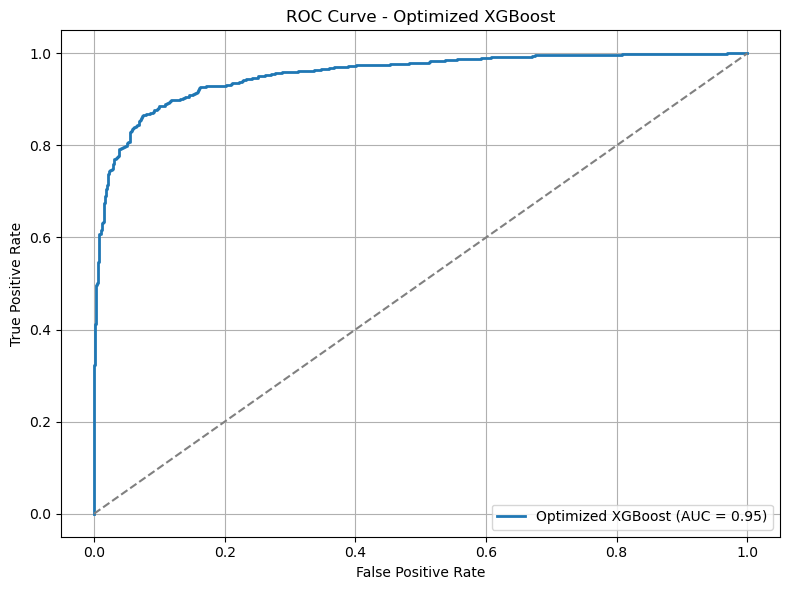


✅ Optimized Hyperparameters: {'max_depth': 8.20355262239579, 'learning_rate': 0.2308049576553235, 'n_estimators': 295.5847394399113}
✅ Best Validation Accuracy (MRFO–WOA): 0.8850787766450418
✅ Final Test AUC: 0.9545


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# === Split Data & Fuzzy Weights Together ===
X_train_sub, X_val, y_train_sub, y_val, weights_sub, weights_val = train_test_split(
    X_train_std, y_train, fuzzy_weights, test_size=0.2, stratify=y_train, random_state=42
)

# === Run MRFO-WOA Optimization ===
opt_params, opt_score = hybrid_optimize(
    model_name="XGBoost",
    bounds=model_param_bounds["XGBoost"],
    X_train=X_train_sub,
    y_train=y_train_sub,
    X_val=X_val,
    y_val=y_val,
    sample_weight=weights_sub
)

# === Train Optimized XGBoost Model on Full Training Set ===
xgb_final = XGBClassifier(
    max_depth=int(opt_params['max_depth']),
    learning_rate=opt_params['learning_rate'],
    n_estimators=int(opt_params['n_estimators']),
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_final.fit(X_train_std, y_train, sample_weight=fuzzy_weights)

# === Predict and Plot ROC Curve ===
y_probs = xgb_final.predict_proba(X_test_std)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Optimized XGBoost (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Optimized XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final Output ===
print("\n✅ Optimized Hyperparameters:", opt_params)
print("✅ Best Validation Accuracy (MRFO–WOA):", opt_score)
print("✅ Final Test AUC:", round(roc_auc, 4))


100%|===================| 5375/5394 [01:19<00:00]        

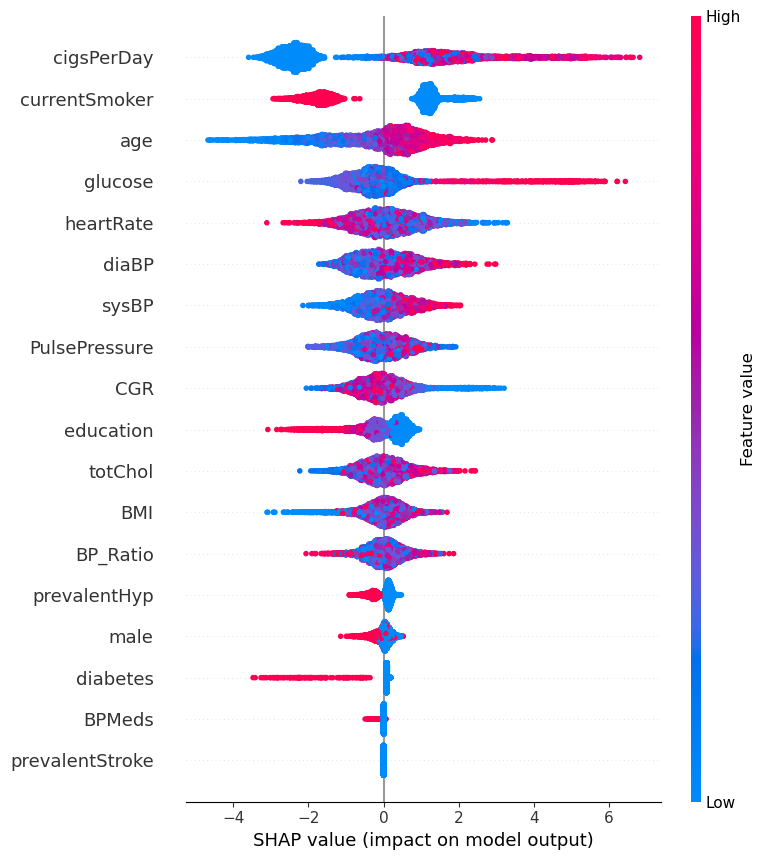

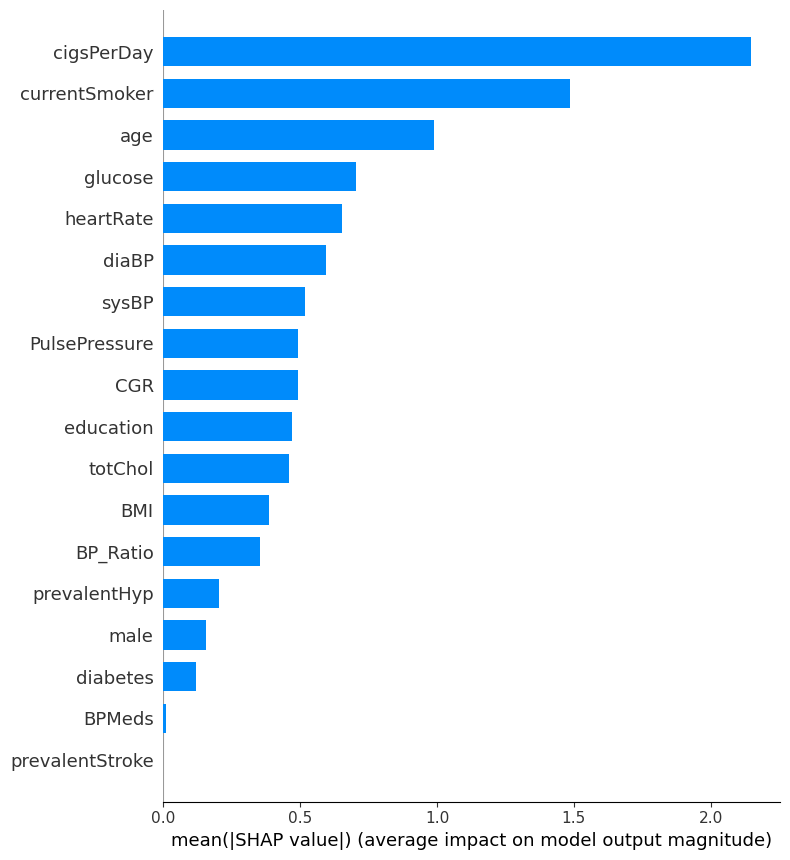

In [7]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming X is your original DataFrame before train_test_split
# And that the same columns were used in X_train_std

# Assign column names to shap plots
X_train_named = pd.DataFrame(X_train_std, columns=X.columns)

# Use this in the SHAP explainer
explainer = shap.Explainer(xgb_final, X_train_named)
shap_values = explainer(X_train_named)

# Updated SHAP plots with real feature names
shap.summary_plot(shap_values, X_train_named)
shap.summary_plot(shap_values, X_train_named, plot_type="bar")